In [97]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [98]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.932722,0.806913,0.653998,0.860533,0.837016,1.0,0.550415,0.000000,0.778617,0.940755
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.692339,0.578107,0.619998,0.0,0.000000,0.000000,0.607899,0.206271
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.000000,0.505180,0.644769,0.603195,0.756754,0.0,0.350566,0.000000,0.899508,0.014040
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.000000,0.000000,0.131632,0.053179,0.774455,0.0,0.000000,0.000000,0.528882,0.305806
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.000000,0.000000,0.085440,0.761822,0.860355,0.0,0.000000,0.000000,0.604102,0.014040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.000000,0.000000,0.149005,0.740343,0.641698,0.0,0.000000,0.694951,0.485461,0.300471
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.000000,0.000000,0.229358,0.640000,0.731908,0.0,0.422815,0.096205,0.502320,0.615334
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.000000,0.000000,0.211405,0.797333,0.896369,0.0,0.234352,0.000000,0.496177,0.402714


In [99]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.00000,0.0,0.016890,0.754178,0.816832,0.0,0.214180,0.000000,0.627881,0.014040
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.00000,0.0,0.380373,0.659297,0.789071,0.0,0.000000,0.296100,0.763348,0.354178
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.68115,0.0,0.127947,1.009412,0.582660,0.0,0.000000,0.473139,0.277717,0.014040
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.00000,0.0,0.203518,0.723574,0.696147,0.0,0.000000,0.000000,0.646765,0.450394
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.00000,0.0,0.214416,0.496175,0.803259,0.0,0.236722,0.000000,0.534480,0.304870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.00000,0.0,0.357494,0.782257,0.591442,0.0,0.000000,0.431213,0.465159,0.540147
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.00000,0.0,0.418615,0.949858,0.559052,0.0,0.269991,0.410777,0.361163,0.561191
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.00000,0.0,0.105689,0.683222,0.878635,0.0,0.182111,0.650452,0.568842,0.398252


In [100]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [101]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [102]:
# compound_model = keras.models.load_model('cd_clf')

In [103]:
# compound_model.summary()

## SHAP evaluation

In [104]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [105]:
import objects

In [106]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True)

Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [107]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [108]:
# shap_values

## Save SHAP values

In [109]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [110]:


with open("../data/models/shap/all_dep_2p11_2p5_mean", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [111]:
shap_values = shap_values[0]


In [112]:
# for i in range(3):
#     shap_values[i] /= 100

In [113]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 7.94654394,  0.        ,  0.        , ...,  0.        ,
         -9.29297925,  0.        ],
        [21.98163959,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  3.8085318 , -0.82350422, ..., -0.93045206,
         -3.01548709,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -8.04219434,
          4.53015322,  0.        ],
        [ 0.        ,  0.        ,  1.43514929, ...,  0.        ,
         -1.77612288,  0.        ]]),
 array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ -3.28957391, -12.24756204,

In [114]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [115]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.0,0.0,0.155668,0.723766,0.785738,0.0,0.0,0.236732,0.678505,0.727315


In [116]:
gmm_model_get_prediction_ae(patient)[0]

array([2.10208717e-56, 1.38514946e-01, 8.61485054e-01])

In [117]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

#### Control

In [118]:
import shap

In [119]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [120]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [121]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [122]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

_explanation.Explanation

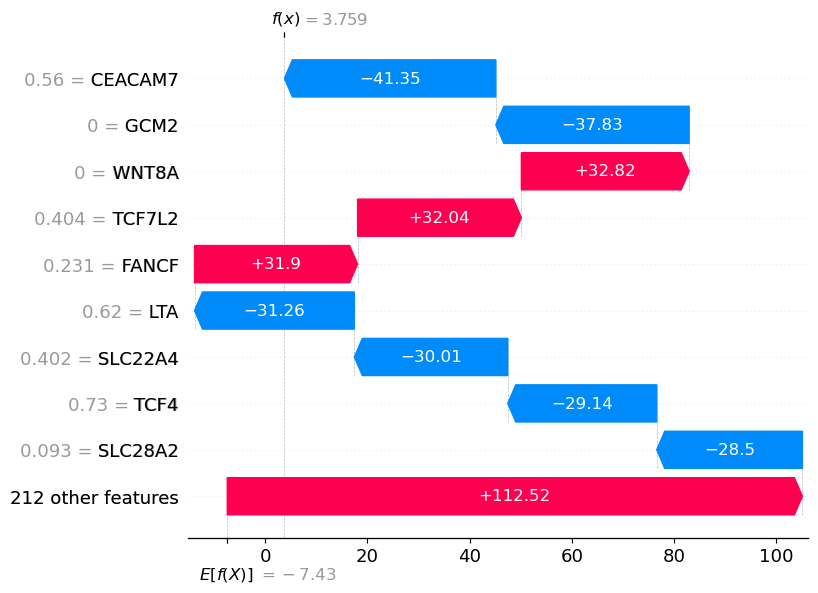

In [123]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [124]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [125]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [126]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

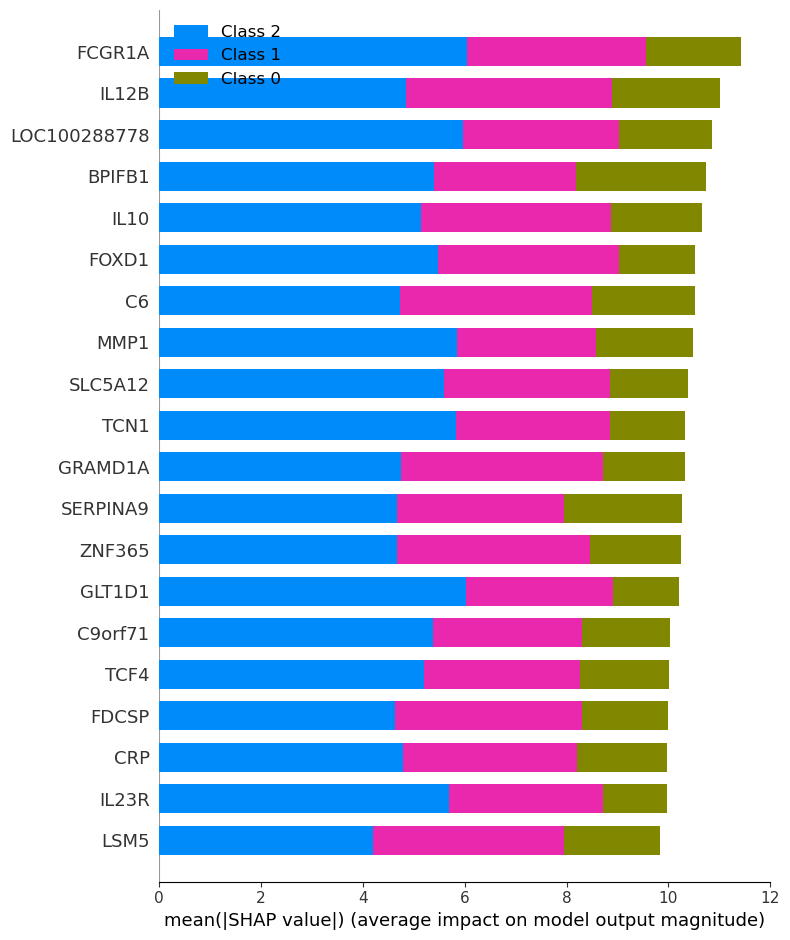

In [127]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


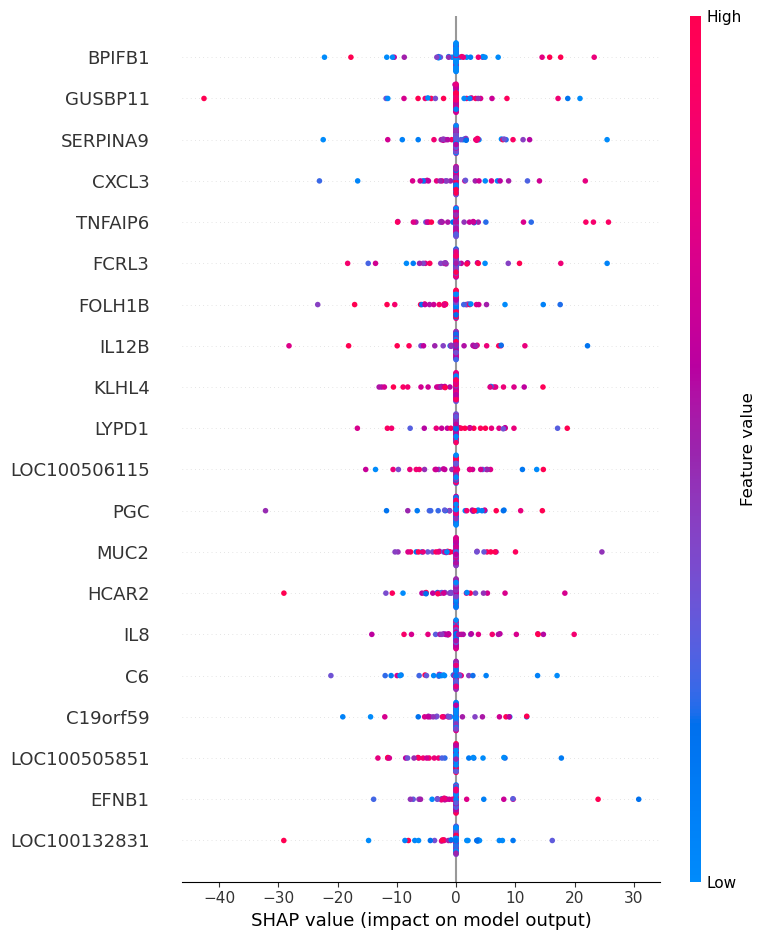

In [128]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

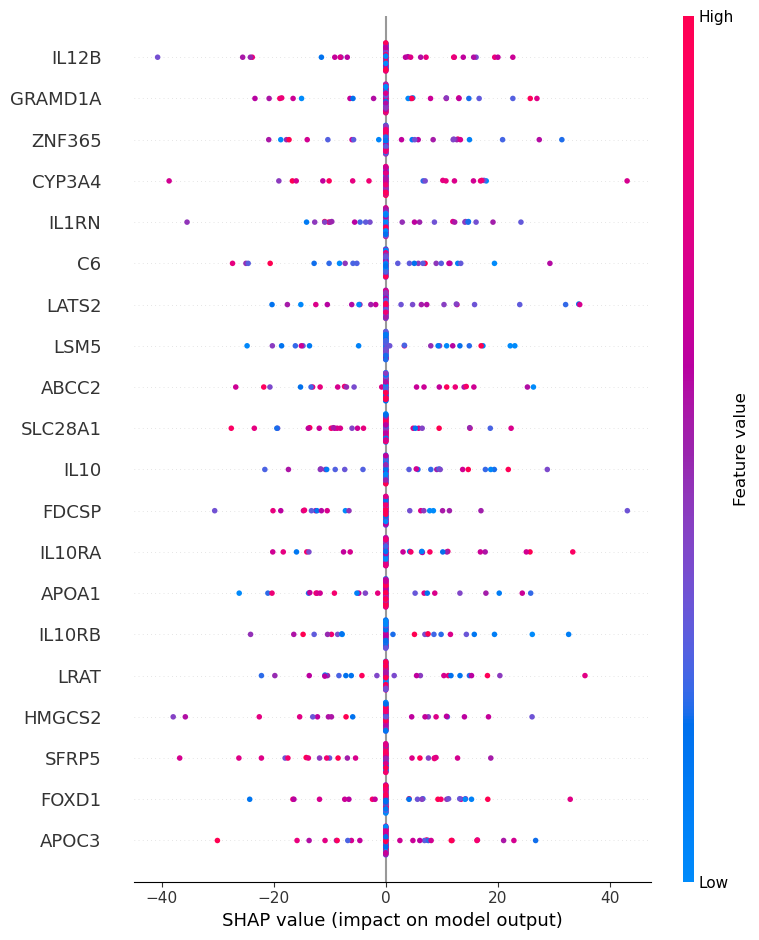

In [129]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

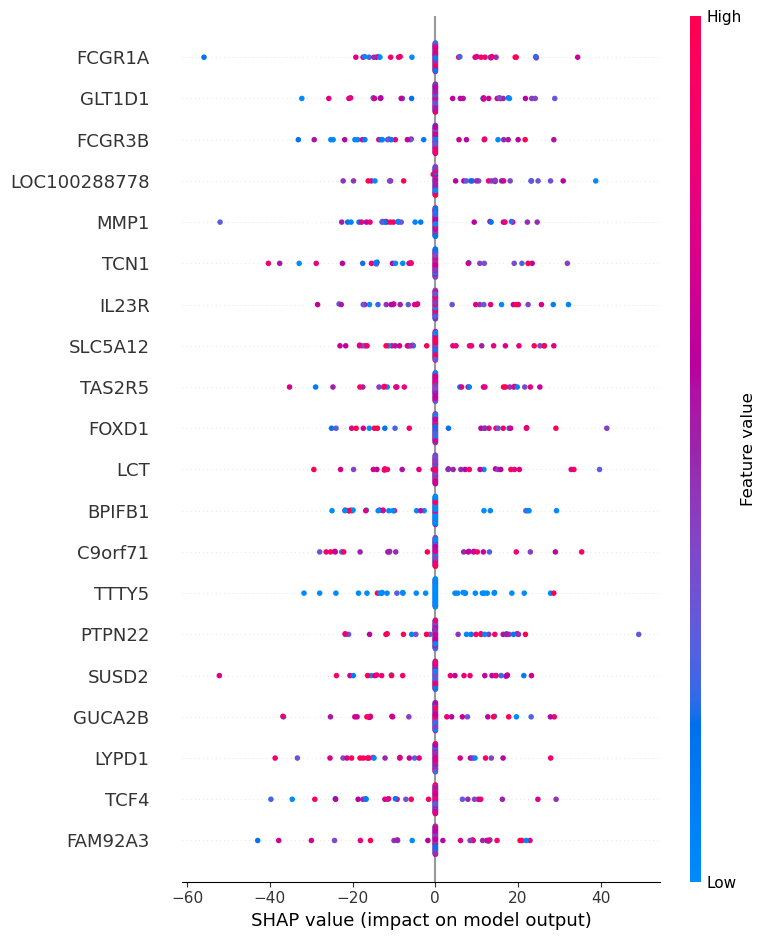

In [130]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

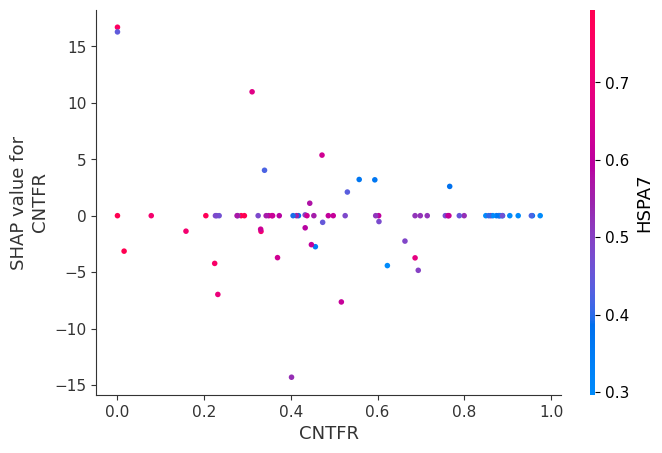

In [131]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

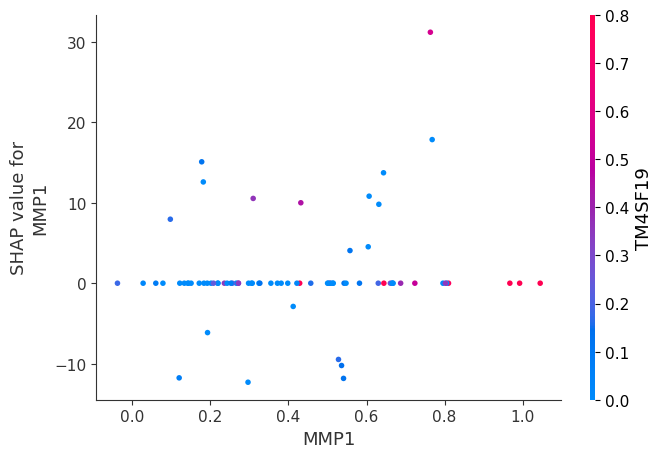

In [132]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

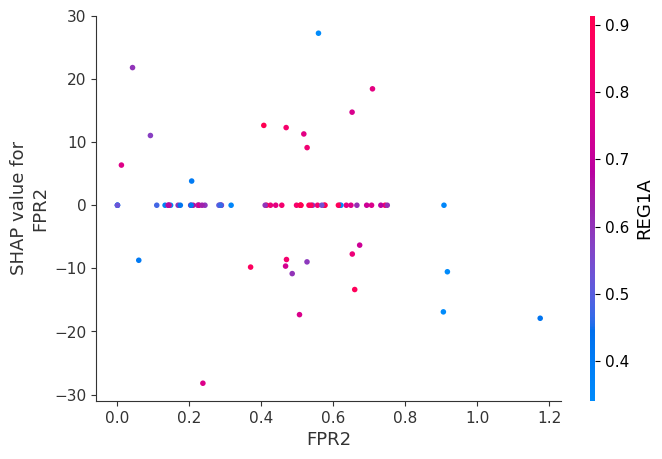

In [133]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [134]:
disease_labels_test.shape

(78,)

In [135]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [136]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 96%|█████████████████████████████████████████████████████████████████████████████   | 213/221 [01:28<00:02,  2.85it/s]No/low signal found from feature 212 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
222it [01:32,  2.12it/s]                                                                                               


In [137]:
# clustering

In [138]:
# clustering.shape

In [139]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [140]:
type(exp)

shap._explanation.Explanation

In [141]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [142]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

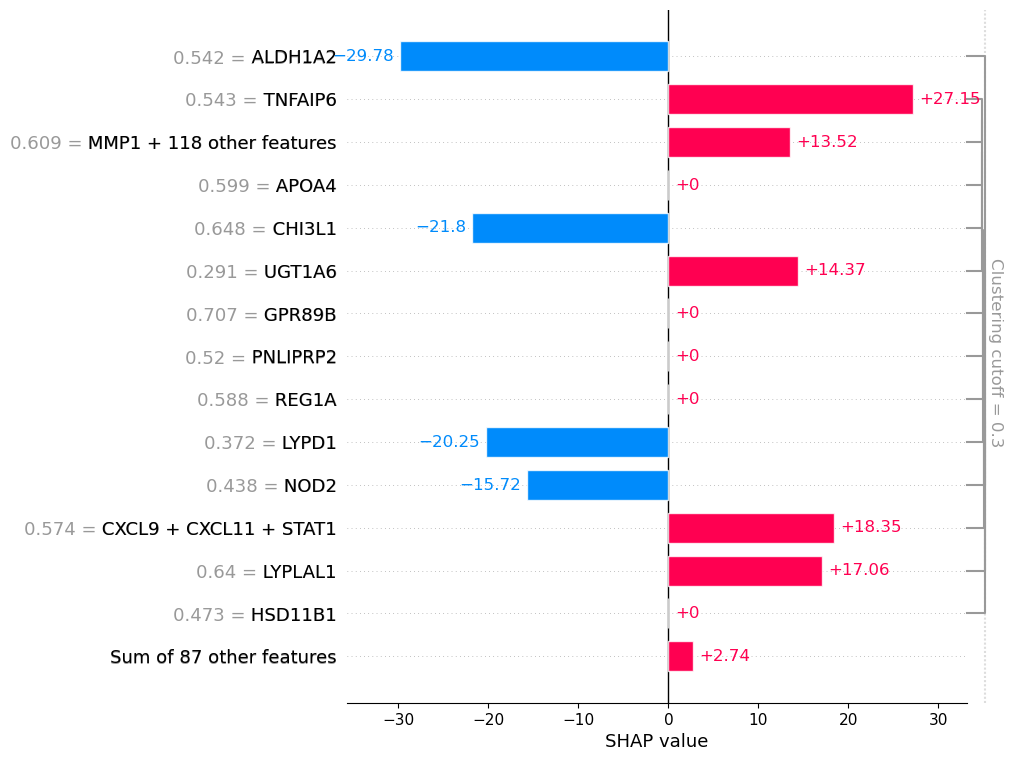

In [143]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [144]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [145]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.847003
167_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,10.706301,0.000000,0.000000,-15.247641,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
196_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23_CD_deep_ulcer,0.000000,8.680405,10.899221,-9.037320,0.000000,0.000000,-8.046671,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.262144,0.000000,0.000000,0.000000,-12.755745
93_CD_deep_ulcer,0.000000,0.000000,-10.723346,0.000000,-11.947616,0.000000,15.998232,0.000000,7.451679,0.000000,...,0.000000,8.552466,0.000000,12.843245,0.000000,7.344379,-17.515228,-8.572980,8.917893,0.000000
229_CD_deep_ulcer,0.000000,0.000000,-14.858147,-18.415759,0.000000,12.308643,0.000000,0.000000,6.013784,0.000000,...,0.000000,0.000000,0.000000,7.967485,0.000000,18.440321,15.574630,0.000000,0.000000,14.343267
46_CD_deep_ulcer,0.000000,0.000000,-13.262355,0.000000,0.000000,0.000000,-14.421653,-41.347638,0.000000,-5.401658,...,18.353771,32.824970,20.981153,0.000000,0.000000,0.000000,0.000000,-16.594288,0.000000,0.000000
176_CD_deep_ulcer,14.627821,0.000000,13.311212,0.000000,-8.012080,12.075484,7.905190,0.000000,0.000000,0.000000,...,-26.360874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.018425,0.000000
49_CD_deep_ulcer,0.000000,0.000000,-30.058948,0.000000,0.000000,0.000000,0.000000,-7.402820,0.000000,0.000000,...,-11.776655,0.000000,0.000000,0.000000,-30.061410,0.000000,0.000000,0.000000,14.461416,0.000000


### Example: CD deep ulcer patients

In [146]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

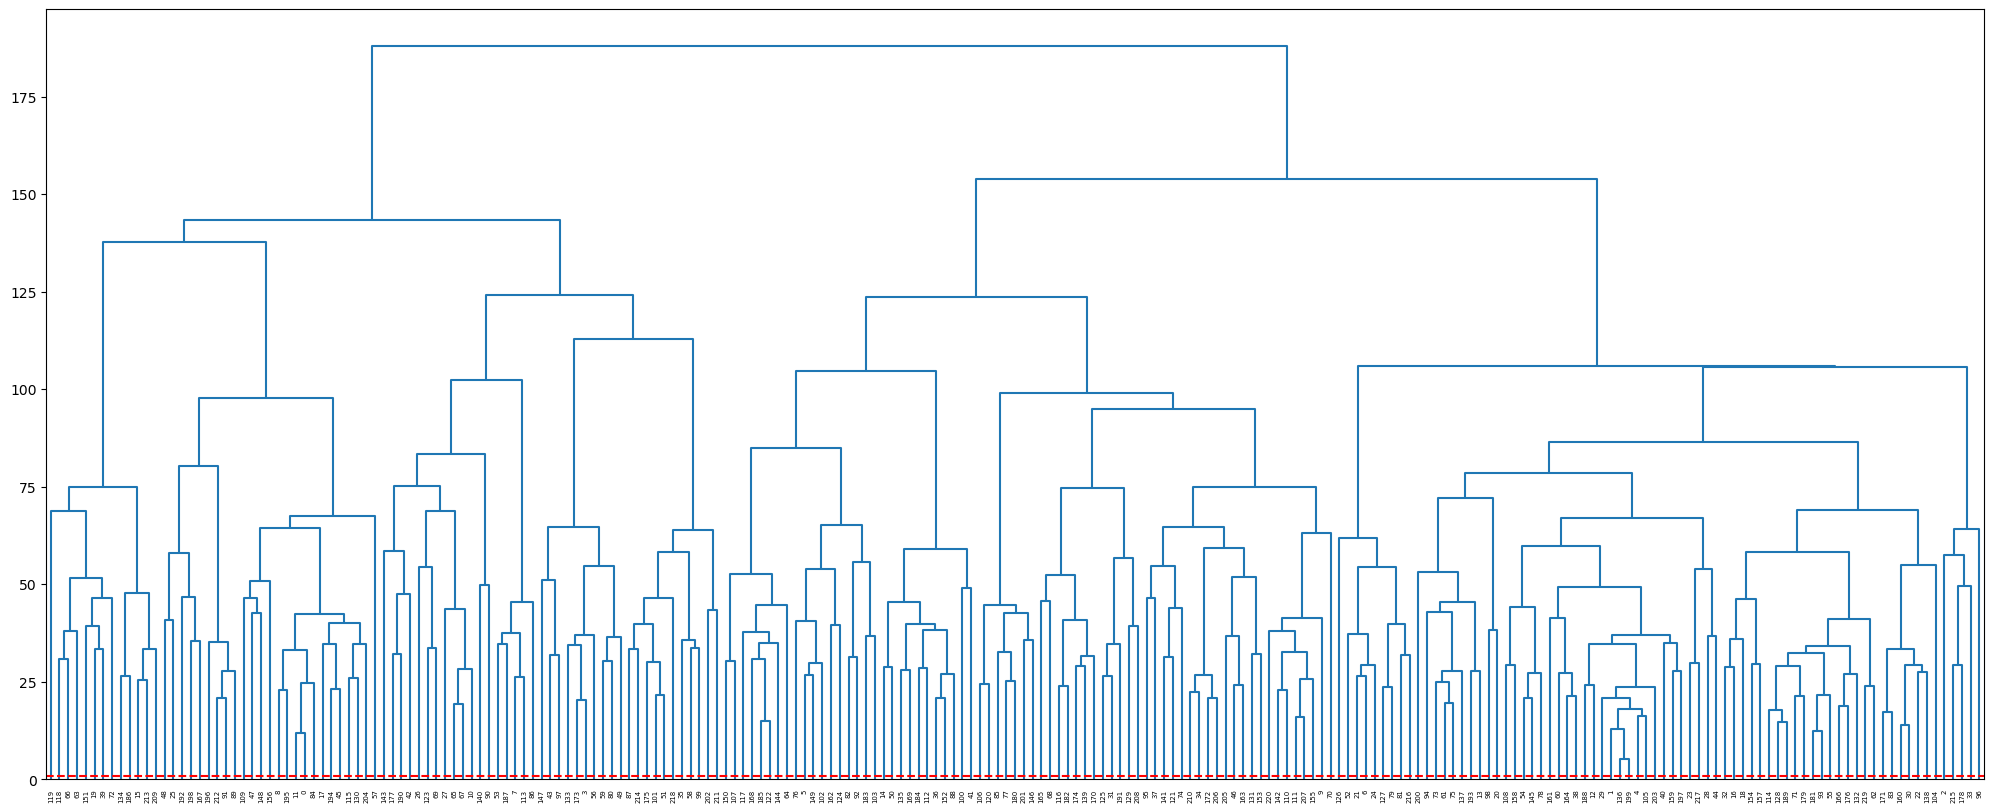

In [147]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [148]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([119, 118,  66,  63, 151,  19,  39,  72, 134, 186,  15, 213, 209,
        48,  25, 192, 198, 167, 196, 212,  91,  89, 109,  47, 148, 156,
         8, 195,  11,   0,  84,  17, 194,  45, 115, 130, 204,  57, 143,
       177, 190,  42,  26, 123,  69,  27,  65,  67,  10, 140,  90,  53,
       187,   7, 113,  86, 147,  43,  97, 133, 173,   3,  56,  59,  80,
        49,  87, 214, 175, 101,  51, 218,  35,  58,  99, 202, 211, 150,
       107, 117, 168, 185, 122, 144,  64,  76,   5, 149, 102, 162, 124,
        82,  92, 183, 103,  14,  50, 135, 169, 184, 112,  36, 152,  88,
       100,  41, 106, 120,  85,  77, 180, 201, 146, 165,  68, 116, 182,
       174, 139, 170, 125,  31, 191, 129, 208,  95,  37, 141, 121,  74,
       210,  34, 172, 206, 205,  46, 163, 131, 153, 220, 142, 110, 111,
       207, 155,   9,  70, 126,  52,  21,   6,  24, 127,  79,  81, 216,
       200,  94,  73,  61,  75, 137, 193,  13,  98,  20, 108, 158,  54,
       145,  78, 161,  60, 164,  38, 188,  12,  29,   1, 136, 19

In [149]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

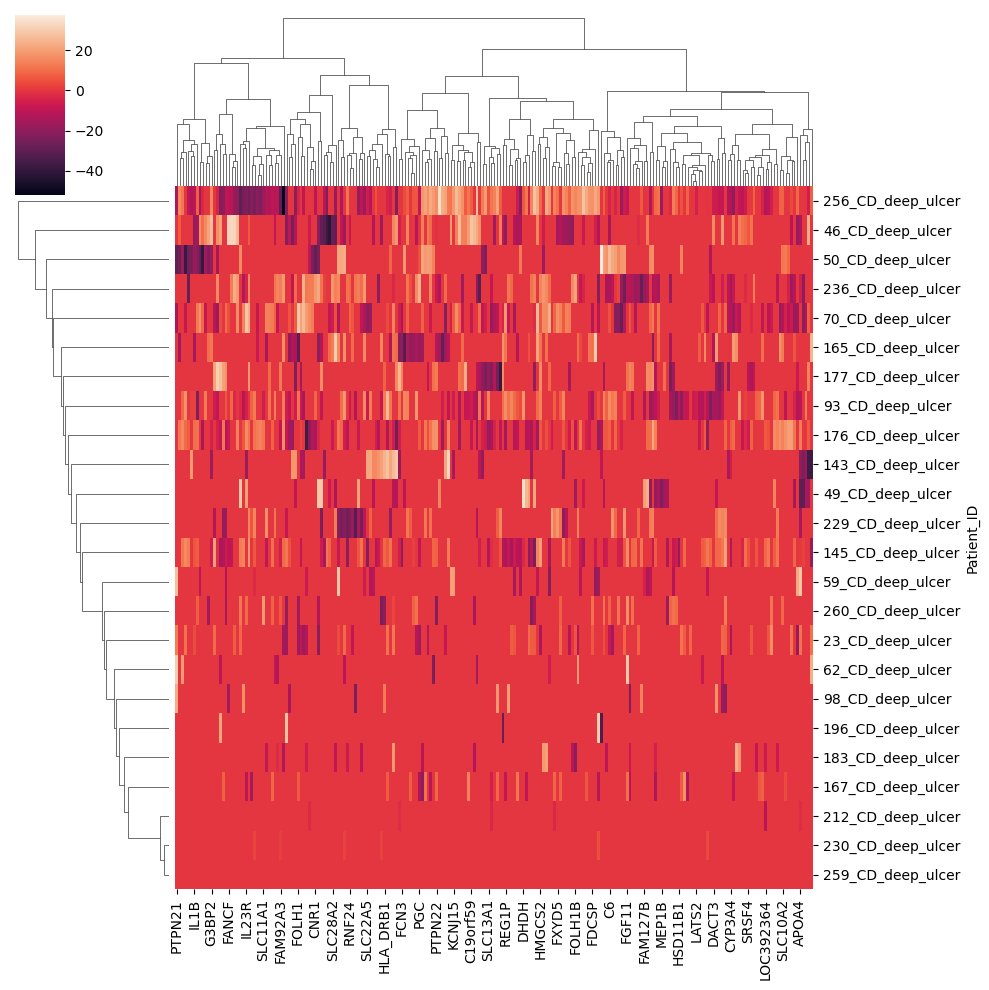

In [150]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [151]:
gene_cluster_cd_deep

array([[136.        , 199.        ,   5.20228983,   2.        ],
       [ 11.        ,   0.        ,  11.87530571,   2.        ],
       [181.        ,  93.        ,  12.26256115,   2.        ],
       [  1.        , 221.        ,  12.79194494,   3.        ],
       [160.        ,  30.        ,  13.83031267,   2.        ],
       [128.        , 189.        ,  14.69569391,   2.        ],
       [185.        , 122.        ,  14.79710105,   2.        ],
       [111.        , 207.        ,  15.8556377 ,   2.        ],
       [  4.        , 105.        ,  16.1321651 ,   2.        ],
       [171.        ,  83.        ,  17.27871163,   2.        ],
       [114.        , 226.        ,  17.83270344,   3.        ],
       [224.        , 229.        ,  18.02171064,   5.        ],
       [166.        , 176.        ,  18.63282461,   2.        ],
       [ 65.        ,  67.        ,  19.38903238,   2.        ],
       [ 61.        ,  75.        ,  19.40496015,   2.        ],
       [173.        ,   3

In [152]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [153]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([118,  66,  63,  19,  39, 151,  72, 119, 134, 186,  15, 213, 209,
         48,  25, 198, 167, 192, 212,  91,  89, 196,  47, 148, 109, 156,
          8, 195,  11,   0,  84, 194,  45,  17, 115, 130, 204,  57, 177,
        190,  42, 143, 123,  69,  26,  65,  67,  10,  27, 140,  90,  53,
        187,   7, 113,  86,  43,  97, 147, 173,   3, 133,  56,  59,  80,
         49,  87, 214, 101,  51, 175, 218,  58,  99,  35, 202, 211, 150,
        107, 185, 122, 168, 144, 117,  64,   5, 149, 102,  76, 162, 124,
         82,  92, 183, 103,  14,  50, 135, 169, 184, 112,  36, 152,  88,
        100,  41, 106, 120,  77, 180,  85, 201, 146, 165,  68, 116, 182,
        174, 139, 170, 125,  31, 191, 129, 208,  95,  37, 141, 121,  74,
        210,  34, 172, 206,  46, 163, 205, 131, 153, 142, 110, 111, 207,
        155, 220,   9,  70,  21,   6,  24,  52, 127,  79,  81, 216, 126,
         61,  75,  73, 137,  94, 193,  13, 200,  98,  20, 108, 158,  54,
        145,  78, 164,  38,  60, 161, 188,  12, 136

In [154]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [155]:
cluster_labels

array([ 30, 180, 220,  61, 181,  86, 149,  54,  27, 146,  48,  29, 177,
       163,  96,  11, 193,  34, 194,   4, 166, 148, 214, 188, 150,  15,
        45,  49, 190, 183, 213, 122, 192, 219, 132,  75, 102, 127, 173,
         5, 187, 106,  41,  57, 191,  33, 135,  23,  14,  66,  97,  70,
       151,  52, 169, 204,  63,  38,  73,  64, 174, 157, 209,   3,  85,
        46,   2,  47, 115,  44, 147, 200,   7, 159, 130, 158,  89, 109,
       171, 153,  65, 154,  92, 211,  31, 111,  56,  67, 104,  21,  51,
        20,  93, 203, 161, 126, 221,  58, 165,  74, 105,  69,  88,  95,
       216, 182, 107,  79, 167,  25, 141, 142, 101,  55, 199,  35, 116,
        84,   1,   8, 108, 129,  81,  43,  91, 121, 156, 152, 197, 124,
        36, 138, 207,  62,   9,  98, 178, 160, 215, 119,  50, 128, 140,
        42,  83, 170, 113,  59,  24,  87,  78,   6, 103, 139, 195, 144,
        26, 196, 168, 185, 212, 175,  90, 136, 172, 114, 205,  17,  82,
        99, 120, 210, 133,  60, 118,  71, 206,  39, 218, 201, 11

In [156]:
df_cd_deep.columns.get_loc("OSM")

63

In [157]:
np.where(cluster_labels == 2) #osm

(array([66], dtype=int64),)

In [158]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,-0.373218,5.774322,-23.585041,0.000000,0.0,0.0,14.627821,AADAC,30
APOA1,24.0,0.361684,1.771880,0.000000,0.000000,0.0,0.0,8.680405,APOA1,180
APOA4,24.0,-1.800279,11.197943,-30.058948,-3.105585,0.0,0.0,28.713189,APOA4,220
APOB,24.0,-0.510378,4.845912,-18.415759,0.000000,0.0,0.0,9.833953,APOB,61
APOC3,24.0,-0.549051,3.268467,-11.947616,0.000000,0.0,0.0,6.782483,APOC3,181
...,...,...,...,...,...,...,...,...,...,...
C16orf78,24.0,0.558187,8.809202,-26.674237,0.000000,0.0,0.0,19.428283,C16orf78,155
C5orf17,24.0,-0.673127,7.464875,-22.821517,0.000000,0.0,0.0,15.574630,C5orf17,189
LOC100132831,24.0,-0.492894,8.221698,-24.061219,0.000000,0.0,0.0,20.143479,LOC100132831,72
LOC100288778,24.0,1.928301,4.678192,0.000000,0.000000,0.0,0.0,16.018425,LOC100288778,208


In [159]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-0.373218,30,AADAC
APOA1,0.361684,180,APOA1
APOA4,-1.800279,220,APOA4
APOB,-0.510378,61,APOB
APOC3,-0.549051,181,APOC3
...,...,...,...
C16orf78,0.558187,155,C16orf78
C5orf17,-0.673127,189,C5orf17
LOC100132831,-0.492894,72,LOC100132831
LOC100288778,1.928301,208,LOC100288778


In [160]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-0.373218,30,AADAC
APOA1,0.361684,180,APOA1
APOA4,-1.800279,220,APOA4
APOB,-0.510378,61,APOB
APOC3,-0.549051,181,APOC3
...,...,...,...
C16orf78,0.558187,155,C16orf78
C5orf17,-0.673127,189,C5orf17
LOC100132831,-0.492894,72,LOC100132831
LOC100288778,1.928301,208,LOC100288778


In [161]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [162]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [163]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [164]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.333819,1,[TLR6]
2,2.023715,1,[PTPN2]
3,0.282347,1,[OSM]
4,-0.697274,1,[FCGR1B]
5,-1.606314,1,[IL1B]
...,...,...,...
217,-3.760409,1,[GUSBP11]
218,-1.414897,1,[TNNT2]
219,-0.305878,1,[GUCA2B]


In [165]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.333819,1,[TLR6],TLR6
2,2.023715,1,[PTPN2],PTPN2
3,0.282347,1,[OSM],OSM
4,-0.697274,1,[FCGR1B],FCGR1B
5,-1.606314,1,[IL1B],IL1B
...,...,...,...,...
217,-3.760409,1,[GUSBP11],GUSBP11
218,-1.414897,1,[TNNT2],TNNT2
219,-0.305878,1,[GUCA2B],GUCA2B


In [166]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [167]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
8,-0.333819,1,[TLR6],TLR6
1,2.023715,1,[PTPN2],PTPN2
2,0.282347,1,[OSM],OSM
3,-0.697274,1,[FCGR1B],FCGR1B
6,-1.606314,1,[IL1B],IL1B
...,...,...,...,...
220,-3.760409,1,[GUSBP11],GUSBP11
217,-1.414897,1,[TNNT2],TNNT2
218,-0.305878,1,[GUCA2B],GUCA2B
219,-1.800279,1,[APOA4],APOA4


In [168]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,2.023715,1,[PTPN2],PTPN2
2,0.282347,1,[OSM],OSM
3,-0.697274,1,[FCGR1B],FCGR1B
4,-1.833498,1,[C9orf71],C9orf71
5,-0.569971,1,[S100A12],S100A12
...,...,...,...,...
217,-1.414897,1,[TNNT2],TNNT2
218,-0.305878,1,[GUCA2B],GUCA2B
219,-1.800279,1,[APOA4],APOA4
220,-3.760409,1,[GUSBP11],GUSBP11


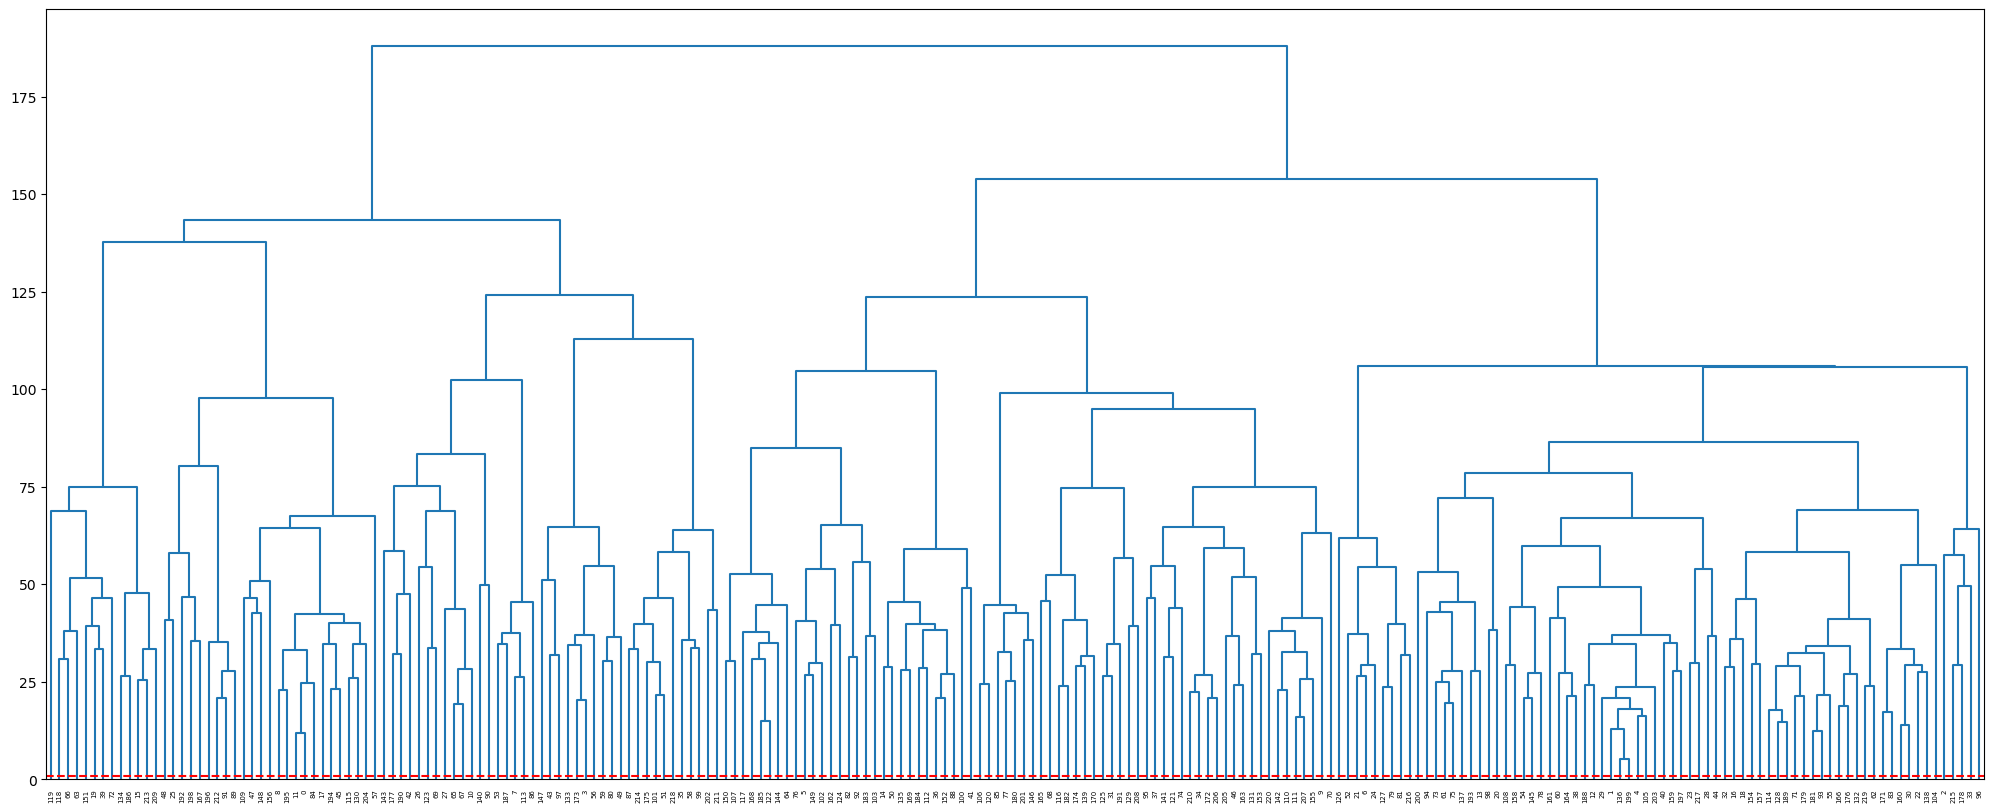

In [169]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

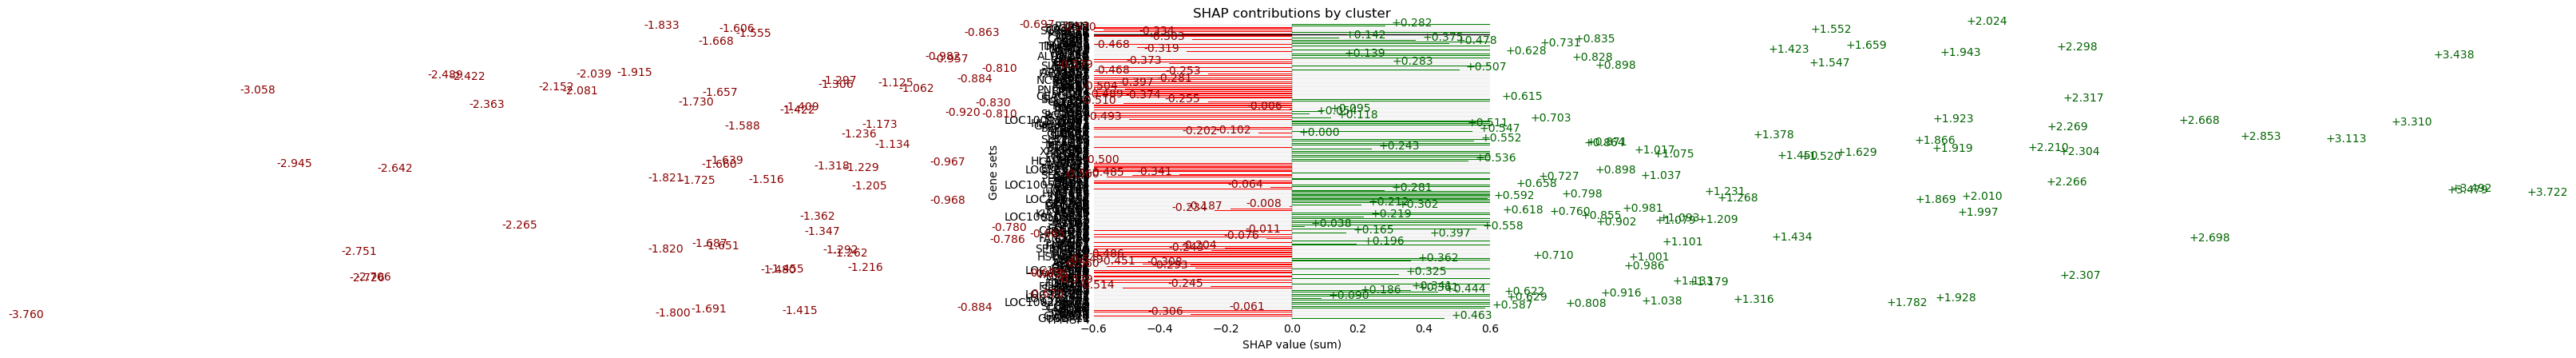

In [170]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [171]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [172]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

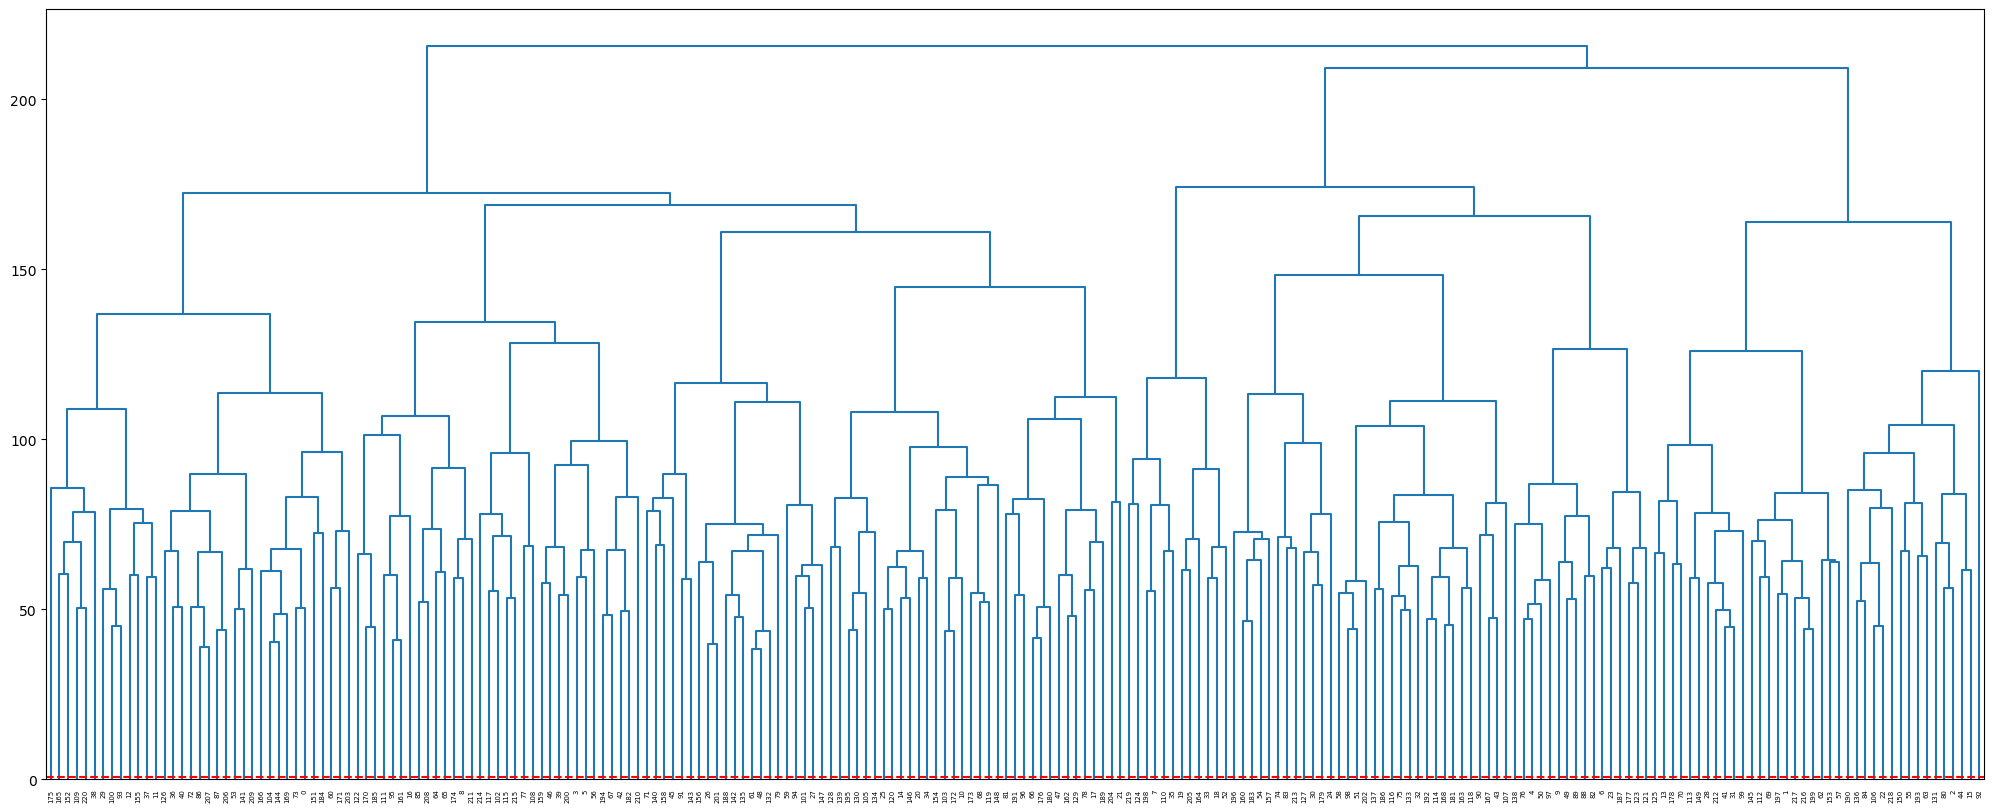

In [173]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [174]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([175, 165, 152, 109, 220,  38,  29, 100,  93,  12, 155,  37,  11,
       126,  36,  40,  72,  86, 207,  87, 206,  53, 141, 209, 166, 104,
       144, 169,  73,   0, 151, 184,  60, 171, 203, 122, 170, 185, 111,
        95, 161,  16,  85, 208,  64,  65, 174,   8, 211, 214, 117, 102,
       115, 215,  77, 108, 159,  46,  39, 200,   3,   5,  56, 194,  67,
        42, 182, 210,  71, 140, 158,  45,  91, 143, 156,  26, 201, 188,
       142, 135,  61,  48, 132,  79,  59,  94, 101,  27, 147, 128, 139,
       195, 130, 105, 134,  25, 120,  14, 146,  20,  34, 154, 103, 172,
        10, 173,  68, 119, 148,  81, 191,  96,  66, 176, 180,  47, 162,
       129,  78,  17, 189, 204,  21, 219, 124, 198,   7, 110,  35,  19,
       205, 164,  33,  18,  52, 196, 160, 183,  54, 157,  74,  83, 213,
       127,  30, 179,  24,  58,  98,  51, 202, 137, 186, 116,  75, 133,
        32, 192, 114, 168, 181, 163, 118,  90, 167,  43, 107, 138,  76,
         4,  50,  97,   9,  49,  89,  88,  82,   6,  23, 187, 17

In [175]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

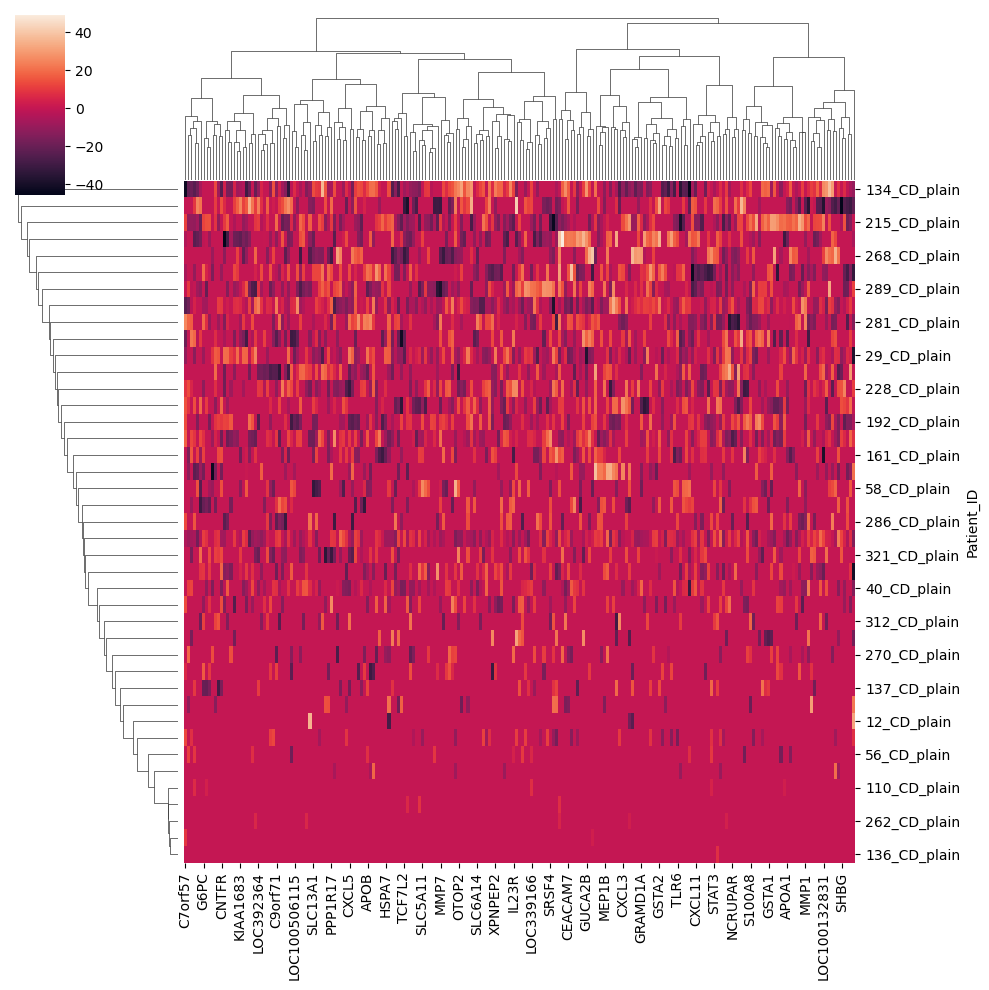

In [176]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [177]:
gene_cluster_cd_plain

array([[ 61.        ,  48.        ,  38.27329113,   2.        ],
       [ 86.        , 207.        ,  38.9314975 ,   2.        ],
       [ 26.        , 201.        ,  39.61228089,   2.        ],
       [104.        , 144.        ,  40.37875943,   2.        ],
       [ 95.        , 161.        ,  40.86554995,   2.        ],
       [ 66.        , 176.        ,  41.4778231 ,   2.        ],
       [221.        , 132.        ,  43.64257114,   3.        ],
       [103.        , 172.        ,  43.68368496,   2.        ],
       [195.        , 130.        ,  43.87242805,   2.        ],
       [ 87.        , 206.        ,  43.88868697,   2.        ],
       [ 98.        ,  51.        ,  44.0549911 ,   2.        ],
       [216.        , 199.        ,  44.26583887,   2.        ],
       [170.        , 185.        ,  44.65788878,   2.        ],
       [ 41.        ,  31.        ,  44.81533837,   2.        ],
       [106.        ,  22.        ,  44.98578258,   2.        ],
       [100.        ,  93

In [178]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [179]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([165, 152, 109, 220,  38, 175, 100,  93,  29,  12, 155,  37,  11,
         36,  40, 126,  86, 207,  72,  87, 206,  53, 141, 209, 104, 144,
        169, 166,  73,   0, 151, 184,  60, 171, 203, 170, 185, 122,  95,
        161, 111,  16,  85, 208,  64,  65, 174,   8, 211, 117, 102, 115,
        215, 214,  77, 108, 159,  46,  39, 200,   3,   5,  56, 194,  67,
         42, 182, 210, 140, 158,  71,  45,  91, 143,  26, 201, 156, 142,
        135, 188,  61,  48, 132,  79, 101,  27,  94, 147,  59, 128, 139,
        195, 130, 105, 134,  25, 120,  14, 146,  20,  34, 103, 172,  10,
        154,  68, 119, 173, 148, 191,  96,  81,  66, 176, 180, 162, 129,
         47,  78,  17, 189, 204,  21, 219, 124, 198,   7, 110,  35,  19,
        205, 164,  33,  18,  52, 160, 183,  54, 157, 196,  83, 213,  74,
         30, 179, 127,  24,  98,  51,  58, 202, 137, 186,  75, 133, 116,
         32, 192, 114, 168, 181, 163, 118, 167,  43,  90, 107,  76,   4,
         50,  97, 138,  49,  89,   9,  88,  82,   6

In [180]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [181]:
cluster_labels

array([ 30, 199, 217,  61, 169,  62, 178, 127,  48, 175, 104,  13,  10,
       185,  98, 220,  42, 120, 134, 130, 100, 123, 209, 179, 147,  96,
        75,  86, 193,   9, 144, 191, 157, 133, 101, 129,  14,  12,   5,
        59,  15, 190,  66, 165, 219,  72,  58, 118,  82, 173, 170, 149,
       135,  22, 138, 213,  63, 204, 150,  89,  33,  81, 205, 215,  45,
        46, 113,  65, 106, 196, 187,  71,  19,  29, 143, 154, 168,  55,
       119,  84, 216, 112, 177, 141, 207,  43,  17,  20, 176, 174, 166,
        73, 221,   8,  87,  39, 111, 171, 148, 194,   7,  85,  51, 102,
        25,  94, 208, 167,  56,   3, 128,  41, 195, 188, 159,  52, 156,
        50, 163, 107,  97, 183,  38, 182, 125, 184,  16, 146,  90, 117,
        93, 218,  83, 155,  95,  79, 206, 152, 172,  91,  69,  23,  78,
        74,  26, 197,  99,  88, 109, 189, 212,  31,   2, 203, 105,  11,
        77, 139,  70,  57, 136,  40, 116, 162, 132,   1,  28, 164, 160,
        27,  36,  34, 103, 108,  47,   6, 114, 181, 186, 145, 11

In [182]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,-1.243674,7.678970,-23.909642,0.0,0.0,0.0000,14.466269,AADAC,30
APOA1,41.0,-2.690307,7.291733,-22.632963,0.0,0.0,0.0000,17.080896,APOA1,199
APOA4,41.0,-1.120890,8.951030,-24.922066,0.0,0.0,0.0000,24.846829,APOA4,217
APOB,41.0,0.930773,9.391180,-22.395822,0.0,0.0,0.0000,22.228596,APOB,61
APOC3,41.0,-0.550936,6.730849,-25.595704,0.0,0.0,0.0000,22.745534,APOC3,169
...,...,...,...,...,...,...,...,...,...,...
C16orf78,41.0,1.041962,6.330442,-14.359588,0.0,0.0,0.0000,20.836957,C16orf78,200
C5orf17,41.0,-0.836075,8.474315,-23.889356,0.0,0.0,0.0000,25.561697,C5orf17,202
LOC100132831,41.0,-0.017231,11.721862,-39.229617,0.0,0.0,0.0000,26.541875,LOC100132831,210
LOC100288778,41.0,3.880727,12.014756,-16.235759,0.0,0.0,10.4723,38.776852,LOC100288778,124


In [183]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-1.243674,30,AADAC
APOA1,-2.690307,199,APOA1
APOA4,-1.120890,217,APOA4
APOB,0.930773,61,APOB
APOC3,-0.550936,169,APOC3
...,...,...,...
C16orf78,1.041962,200,C16orf78
C5orf17,-0.836075,202,C5orf17
LOC100132831,-0.017231,210,LOC100132831
LOC100288778,3.880727,124,LOC100288778


In [184]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-1.243674,30,AADAC
APOA1,-2.690307,199,APOA1
APOA4,-1.120890,217,APOA4
APOB,0.930773,61,APOB
APOC3,-0.550936,169,APOC3
...,...,...,...
C16orf78,1.041962,200,C16orf78
C5orf17,-0.836075,202,C5orf17
LOC100132831,-0.017231,210,LOC100132831
LOC100288778,3.880727,124,LOC100288778


In [185]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.152794,1,[OTOP3]
2,0.263253,1,[C19orf59]
3,-0.321711,1,[ALDH1A2]
4,-1.415507,1,[LOC100505851]
5,-1.376993,1,[HSD11B1]
...,...,...,...
217,-1.120890,1,[APOA4]
218,-0.764444,1,[SUSD2]
219,-2.647544,1,[IL10]


In [186]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.152794,1,[OTOP3],OTOP3
2,0.263253,1,[C19orf59],C19orf59
3,-0.321711,1,[ALDH1A2],ALDH1A2
4,-1.415507,1,[LOC100505851],LOC100505851
5,-1.376993,1,[HSD11B1],HSD11B1
...,...,...,...,...
217,-1.120890,1,[APOA4],APOA4
218,-0.764444,1,[SUSD2],SUSD2
219,-2.647544,1,[IL10],IL10


In [187]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [188]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
6,-0.152794,1,[OTOP3],OTOP3
1,0.263253,1,[C19orf59],C19orf59
2,-0.321711,1,[ALDH1A2],ALDH1A2
3,-1.415507,1,[LOC100505851],LOC100505851
4,-1.376993,1,[HSD11B1],HSD11B1
...,...,...,...,...
216,-1.120890,1,[APOA4],APOA4
217,-0.764444,1,[SUSD2],SUSD2
219,-2.647544,1,[IL10],IL10
220,0.488297,1,[CYP3A7],CYP3A7


In [189]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,0.263253,1,[C19orf59],C19orf59
2,-0.321711,1,[ALDH1A2],ALDH1A2
3,-1.415507,1,[LOC100505851],LOC100505851
4,-1.376993,1,[HSD11B1],HSD11B1
5,0.936265,1,[C7orf57],C7orf57
...,...,...,...,...
217,-0.764444,1,[SUSD2],SUSD2
218,-0.304011,1,[SHBG],SHBG
219,-2.647544,1,[IL10],IL10
220,0.488297,1,[CYP3A7],CYP3A7


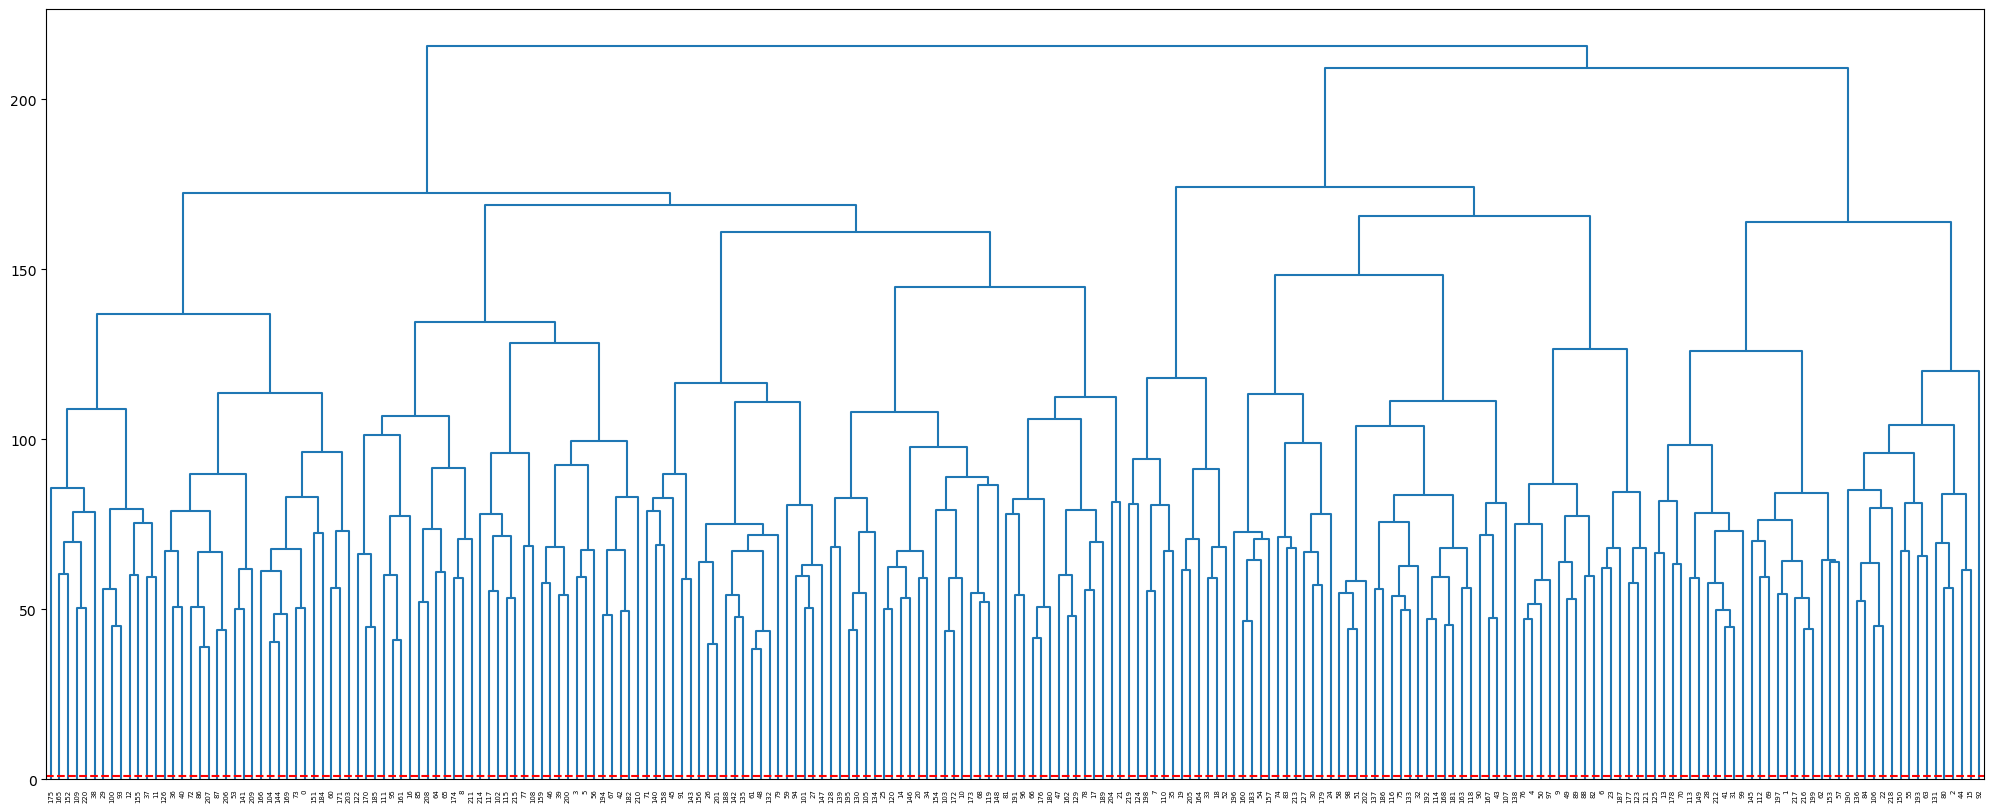

In [190]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

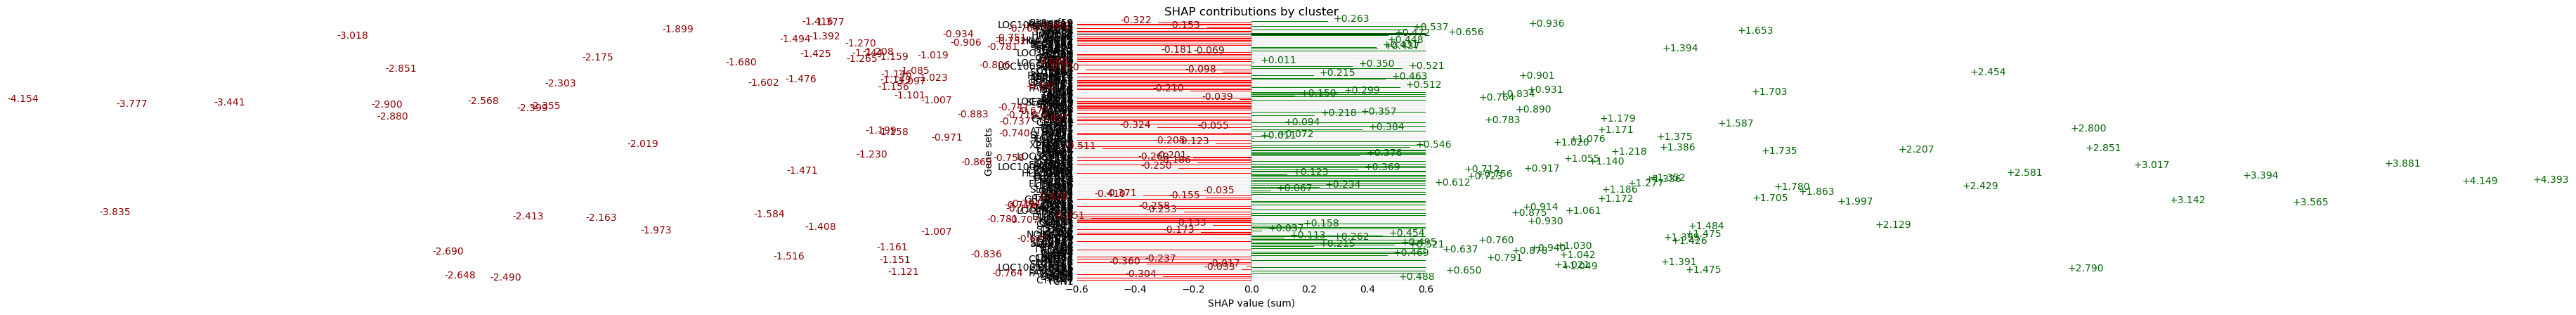

In [191]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [192]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")